<a href="https://colab.research.google.com/github/ritamsarkar2000/ML/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling


import pandas as pd

import matplotlib.pyplot as plt

import numpy as np

import seaborn as sns

import pathlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names= column_names, 
                          na_values = "?", comment= '\t',
                          sep= " ", skipinitialspace= True)
dataset = raw_dataset.copy()
print(dataset.tail())
dataset.head()

      MPG  Cylinders  Displacement  ...  Acceleration  Model Year  Origin
393  27.0          4         140.0  ...          15.6          82       1
394  44.0          4          97.0  ...          24.6          82       2
395  32.0          4         135.0  ...          11.6          82       1
396  28.0          4         120.0  ...          18.6          82       1
397  31.0          4         119.0  ...          19.4          82       1

[5 rows x 8 columns]


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [0]:
dataset = dataset.dropna()

In [0]:
origin = dataset.pop('Origin')

In [7]:
dataset['USA']= (origin==1)*1.0
dataset['Europe']= (origin==2)*1.0
dataset['Japan']= (origin== 3)*1.0

dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
dataset.iloc[199:210]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
201,18.5,6,250.0,110.0,3645.0,16.2,76,1.0,0.0,0.0
202,17.5,6,258.0,95.0,3193.0,17.8,76,1.0,0.0,0.0
203,29.5,4,97.0,71.0,1825.0,12.2,76,0.0,1.0,0.0
204,32.0,4,85.0,70.0,1990.0,17.0,76,0.0,0.0,1.0
205,28.0,4,97.0,75.0,2155.0,16.4,76,0.0,0.0,1.0
206,26.5,4,140.0,72.0,2565.0,13.6,76,1.0,0.0,0.0
207,20.0,4,130.0,102.0,3150.0,15.7,76,0.0,1.0,0.0
208,13.0,8,318.0,150.0,3940.0,13.2,76,1.0,0.0,0.0
209,19.0,4,120.0,88.0,3270.0,21.9,76,0.0,1.0,0.0
210,19.0,6,156.0,108.0,2930.0,15.5,76,0.0,0.0,1.0


In [0]:
train_data = dataset.sample(frac= 0.8,random_state=0)
test_data = dataset.drop(train_data.index)

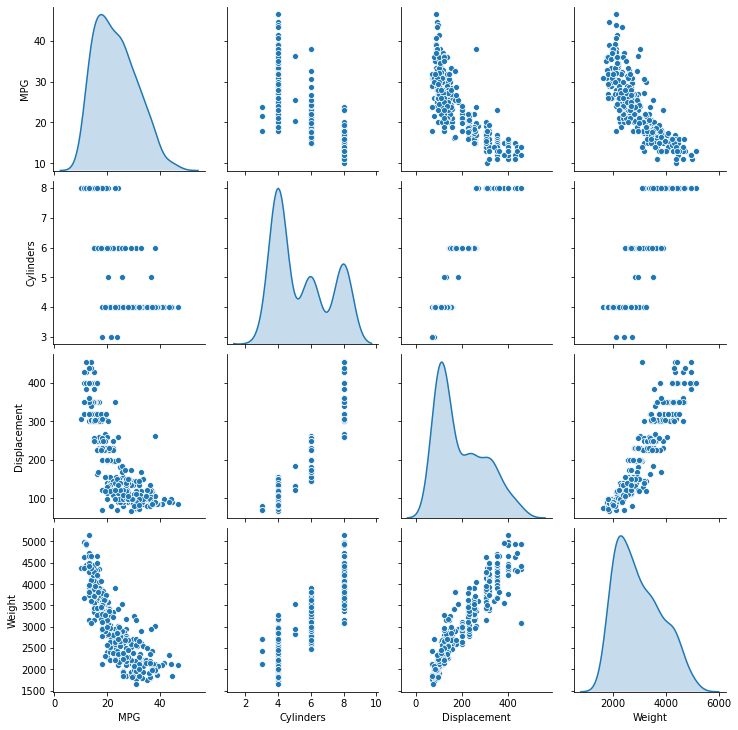

In [10]:
sns.pairplot(train_data[["MPG", "Cylinders", "Displacement", "Weight"]],diag_kind='kde')

In [11]:
train_stats = train_data.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [0]:
train_labels = train_data.pop("MPG")
test_labels = test_data.pop("MPG")

In [0]:
#normalize the data for model feedind as well as 
#model evaluating
#and model testing

def normalize(x):
  return(x - train_stats['mean']) / train_stats['std']

normalized_train_data = normalize(train_data)
normalized_test_data = normalize(test_data)

In [43]:
def build_model():
  model = tf.keras.Sequential([
                             tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(1)
  ])

  model.compile(loss = 'mse',
              optimizer=tf.keras.optimizers.RMSprop(0.001),
              metrics=['mae', 'mse'])

  return model


model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [44]:
example_batch= normalized_train_data[:10]
example_result= model.predict(example_batch)
example_result

array([[27.487503 ],
       [23.772291 ],
       [12.5149555],
       [37.22549  ],
       [37.076317 ],
       [20.116642 ],
       [38.728466 ],
       [30.605064 ],
       [21.132769 ],
       [20.990183 ]], dtype=float32)

In [45]:
train_data.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
146,4,90.0,75.0,2125.0,14.5,74,1.0,0.0,0.0
282,4,140.0,88.0,2890.0,17.3,79,1.0,0.0,0.0
69,8,350.0,160.0,4456.0,13.5,72,1.0,0.0,0.0
378,4,105.0,63.0,2125.0,14.7,82,1.0,0.0,0.0
331,4,97.0,67.0,2145.0,18.0,80,0.0,0.0,1.0


In [46]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [47]:
EPOCHS = 1000

history = model.fit(
  normalized_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:2.3667,  mae:0.9399,  mse:2.3667,  val_loss:10.4809,  val_mae:2.4397,  val_mse:10.4809,  
....................................................................................................
Epoch: 100, loss:2.2057,  mae:0.8726,  mse:2.2057,  val_loss:10.5789,  val_mae:2.4380,  val_mse:10.5789,  
....................................................................................................
Epoch: 200, loss:1.9696,  mae:0.8874,  mse:1.9696,  val_loss:11.4606,  val_mae:2.5486,  val_mse:11.4606,  
....................................................................................................
Epoch: 300, loss:1.9832,  mae:0.8742,  mse:1.9832,  val_loss:11.7546,  val_mae:2.5713,  val_mse:11.7546,  
....................................................................................................
Epoch: 400, loss:1.7961,  mae:0.8135,  mse:1.7961,  val_loss:11.8384,  val_mae:2.5696,  val_mse:11.8384,  
..............................................................

In [48]:
hist = pd.DataFrame(history.history)
hist['epochs'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epochs
995,1.301558,0.650298,1.301558,12.736114,2.651441,12.736114,995
996,1.262044,0.653584,1.262044,12.841433,2.693342,12.841433,996
997,1.457060,0.669018,1.457060,12.982852,2.710706,12.982852,997
998,1.365981,0.654150,1.365981,12.759010,2.675622,12.759010,998
999,1.265908,0.594760,1.265908,13.096288,2.551441,13.096288,999


In [0]:
def plot_history(history):
  hist=pd.DataFrame(history.history)
  hist['epochs'] = history.epoch

  plt.figure()
  plt.xlabel('epochs')
  plt.ylabel('mae[mpg]')
  plt.plot(hist['epochs'], hist['mae'],
           label='train error')
  plt.plot(hist['epochs'], hist['val_mae'],
           label='value error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('epochs')
  plt.ylabel('mse[mpg]')
  plt.plot(hist['epochs'], hist['mse'],
           label= 'train error')
  plt.plot(hist['epochs'], hist['val_mse'],
           label= 'value error')
  plt.ylim([0,20])
  plt.legend()

  plt.show()

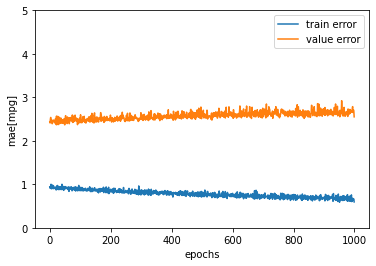

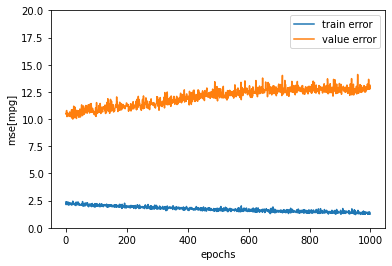

In [50]:
plot_history(history)


Epoch: 0, loss:566.0740,  mae:22.5496,  mse:566.0740,  val_loss:545.3867,  val_mae:22.0794,  val_mse:545.3867,  
.........................................................................................

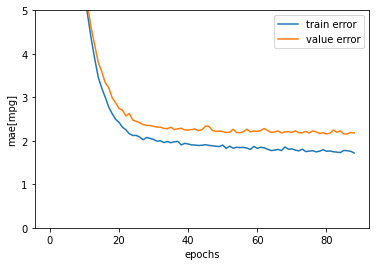

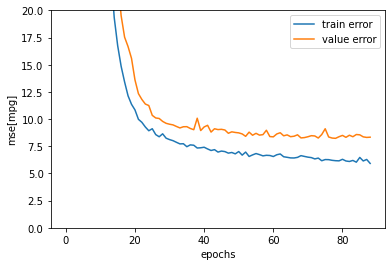

In [51]:
#to solve the overfitting

model= build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normalized_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

plot_history(early_history)

In [52]:
loss, mae , mse = model.evaluate(normalized_test_data, test_labels, verbose=0)


print("\n the mean absolute error is:{:5.2f}MPG". format(mae))


 the mean absolute error is: 1.85MPG


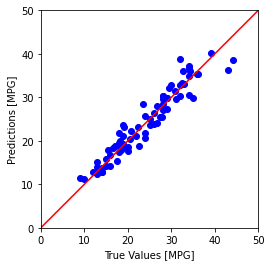

In [53]:
test_predictions = model.predict(normalized_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions, color='b')
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims,lims, color='r')

In [54]:
tp=list(test_predictions)
prediction_list=pd.DataFrame(tp, columns=['predicted MPG'])
prediction_list

,predicted MPG
0,15.852403
1,11.193963
2,11.505585
3,23.538332
4,21.112410
...,...
73,30.452328
74,35.400661
75,36.661064
76,38.898743


In [55]:
test_labelnew= pd.DataFrame(np.array(test_labels), columns=['real MPG'])
test_lebelnew

,real MPG
0,15.0
1,10.0
2,9.0
3,25.0
4,19.0
...,...
73,34.0
74,36.0
75,34.0
76,32.0


In [56]:
PREDICTION_vs_LABEL= pd.DataFrame(pd.concat([prediction_list, test_lebelnew], axis=1))
PREDICTION_vs_LABEL

,predicted MPG,real MPG
0,15.852403,15.0
1,11.193963,10.0
2,11.505585,9.0
3,23.538332,25.0
4,21.112410,19.0
...,...,...
73,30.452328,34.0
74,35.400661,36.0
75,36.661064,34.0
76,38.898743,32.0
